<h2><center> <span style = "font-family: Babas; font-size: 2em;"> BBC News Text Classification </span> </center></h2>
<h4><center> <span style = "font-family: Babas; font-size: 2em; font-style: italic"> With Parameter Efficient Fine Tuning </span> </center></h4>
<h4><center> <span style = "font-family: Babas; font-size: 2em;"> Gökalp Eren Akol </span> </center></h4>

---

# Overview

The objective of the project is to classify BBC news articles into five predefined categories: business, entertainment, politics, sport, and tech. We carried out the following steps in this notebook:

- Performed basic exploratory data analysis, examining class distributions, average article lengths, and key textual features such as word counts and character frequencies across categories.

- Employed several text normalization techniques on article texts, including lowercasing, punctuation removal, and contraction expansion.

- Utilized the PEFT (Parameter-Efficient Fine-Tuning) framework to fine-tune two pre-trained BERT models: bert-base-uncased and bert-base-cased, applying the LoRA method to enable efficient adaptation with fewer trainable parameters.

- Conducted training on the BBC full-text dataset, evaluated model performance using validation accuracy, and compared results across both models.

- Achieved the highest validation accuracy of 0.878 using the bert-base-cased model fine-tuned with LoRA.

- Emphasized that with larger computational resources, more advanced prompt tuning, and extended training epochs, higher accuracy scores are likely to be achieved.


---


# Importing Libraries

If you are running this notebook for the first time, restart the session after running install/import cells.

In [ ]:
!pip install evaluate
!pip install wordcloud -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.4 MB/s eta 0:00:00


In [ ]:
# File system manangement
import time, psutil, os

# Data manipulation
import numpy as np
import pandas as pd

# Plotting and visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# NLP
import string, re, nltk
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
!pip install num2words
from num2words import num2words
!pip install pyspellchecker
from spellchecker import SpellChecker
from nltk.stem.porter import PorterStemmer
import spacy
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud,STOPWORDS

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Scipy
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix

# Train-test split and cross validation
from sklearn.model_selection import train_test_split, ParameterGrid

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

# Model evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score

#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

#Transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer
from peft import get_peft_model, LoraConfig, TaskType


# Others
import evaluate
from tqdm import tqdm
!pip install gensim
import json
import gensim
from sklearn.decomposition import TruncatedSVD

# Reading csv Data

In [ ]:
import kagglehub
path = kagglehub.dataset_download("alfathterry/bbc-full-text-document-classification")


100%|██████████| 1.84M/1.84M [00:01<00:00, 1.69MB/s]

Extracting files...


In [ ]:
import pandas as pd
import os

csv_file_path = os.path.join(path, 'bbc_data.csv')

data = pd.read_csv(csv_file_path, names=['description', 'label'], encoding='UTF-8')
display(data.head())

,description,label
0,data,labels
1,Musicians to tackle US red tape Musicians gro...,entertainment
2,"U2s desire to be number one U2, who have won ...",entertainment
3,Rocker Doherty in on-stage fight Rock singer ...,entertainment
4,Snicket tops US box office chart The film ada...,entertainment


In [ ]:
df=data.iloc[1:]

In [ ]:
df.head(2)

,description,label
1,Musicians to tackle US red tape Musicians gro...,entertainment
2,"U2s desire to be number one U2, who have won ...",entertainment


In [ ]:
df['label'].value_counts()

,count
label,
sport,511
business,510
politics,417
tech,401
entertainment,386


In [ ]:
print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data.shape)}).to_string())

Memory usage       0.03 MB
Dataset shape    (2226, 2)


In [ ]:
df['description'].iloc[0]

'Musicians to tackle US red tape  Musicians groups are to tackle US visa regulations which are blamed for hindering British acts chances of succeeding across the Atlantic.  A singer hoping to perform in the US can expect to pay $1,300 (xc2xa3680) simply for obtaining a visa. Groups including the Musicians Union are calling for an end to the "raw deal" faced by British performers. US acts are not faced with comparable expense and bureaucracy when visiting the UK for promotional purposes.  Nigel McCune from the Musicians Union said British musicians are "disadvantaged" compared to their US counterparts. A sponsor has to make a petition on their behalf, which is a form amounting to nearly 30 pages, while musicians face tougher regulations than athletes and journalists. "If you make a mistake on your form, you risk a five-year ban and thus the ability to further your career," says Mr McCune.  "The US is the worlds biggest music market, which means something has to be done about the creaky 

In [ ]:
print(pd.Series({"Number of observations with missing values": len(data) - len(data.dropna()),
                 "Number of duplicate observations": data.duplicated().sum()}).to_string())

Number of observations with missing values     0
Number of duplicate observations              99


In [ ]:
data.dropna(inplace = True)
data.drop_duplicates(inplace = True)
data.reset_index(drop = True, inplace = True)

Label Encodings
- sport  -- 	  0
- business -- 	1
- politics --	  2
- tech --	  3
- entertainment --	  4

In [ ]:
label_dict = {'sport': 0, 'business': 1, 'politics': 2,'tech' : 3 , 'entertainment' : 4}
data.replace({'label': label_dict}, inplace = True)

# Exploratory Data Analysis


The objective of the project is to classify text data into 5 labels.

In [ ]:
data_s = data[data['label'] == 0]
data_b = data[data['label'] == 1]
data_p = data[data['label'] == 2]
data_t = data[data['label'] == 3]
data_e = data[data['label'] == 4]

In [ ]:
data_t.head()

,description,label
1781,Mobiles rack up 20 years of use Mobile phones...,3
1782,Broadband steams ahead in the US More and mor...,3
1783,EA to take on film and TV giants Video game g...,3
1784,Microsoft releases patches Microsoft has warn...,3
1785,China to overtake US net use The Chinese net-...,3


In [ ]:
ratios = np.array([len(data_s), len(data_b), len(data_p),len(data_t),len(data_e)])/len(data)

In [ ]:
ratios

array([0.2374236 , 0.23648331, 0.18946874, 0.16267043, 0.17348378])

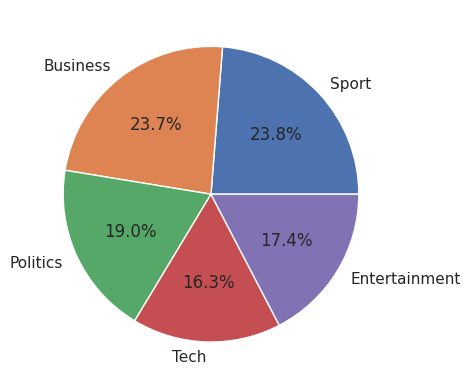

In [ ]:
plt.pie(ratios, labels = ['Sport', 'Business', 'Politics','Tech','Entertainment'], autopct='%1.1f%%')
plt.show()

Description Lengths For Each Label

In [ ]:
data['desc_len'] = data['description'].apply(len)

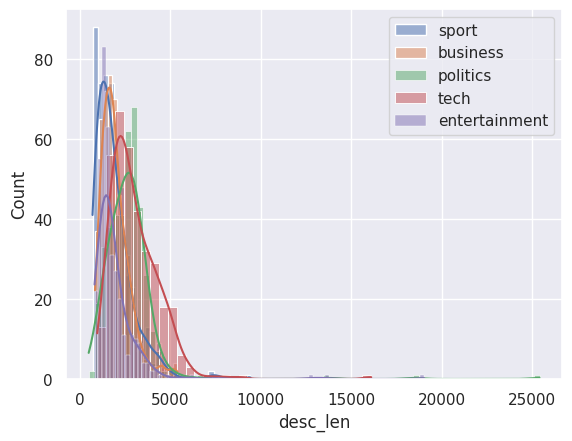

In [ ]:
for a, b in label_dict.items():
    subset = data[data['label'] == b]
    sns.histplot(subset['desc_len'], label=a, kde=True)
plt.legend()
plt.show()

Word Counts For Each Label

In [ ]:
data['word_count'] = data['description'].str.split().str.len()


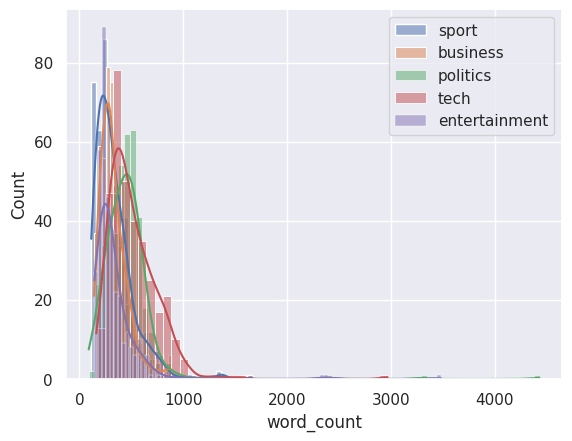

In [ ]:
for a,b in label_dict.items():
  subset=data[data['label']==b]
  sns.histplot(subset['word_count'], label=a, kde=True )

plt.legend()
plt.show()

Average Word Length for each label

In [ ]:
data['avg_word_length']= data['description'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))

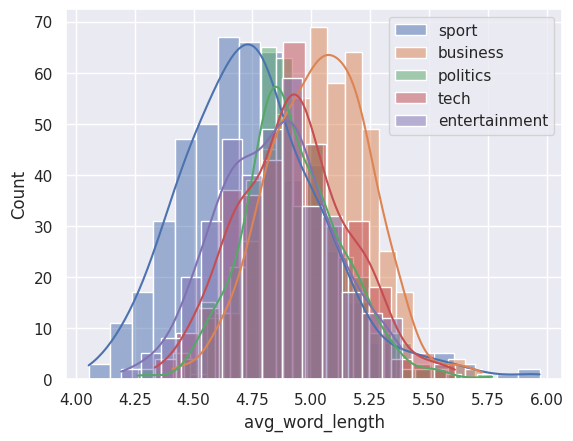

In [ ]:
for a,b in label_dict.items():
  subset=data[data['label']==b]
  sns.histplot(subset['avg_word_length'],label=a,kde=True)

plt.legend()
plt.show()

#### Word Clouds

In [ ]:
extra_stopwords = {"said", "will", "mr"}


stop_words = list(STOPWORDS.union(extra_stopwords))
tfidf = TfidfVectorizer(stop_words=stop_words, max_features=1000)

X_tfidf=tfidf.fit_transform(df['description'])
feature_names=tfidf.get_feature_names_out()

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.



In [ ]:
df = df.reset_index(drop=True)

In [ ]:
def top_tfidf_words_per_label(label):
    idx = df[df['label'] == label].index
    avg_tfidf = X_tfidf[idx].mean(axis=0).A1
    top_n = np.argsort(avg_tfidf)[-10:][::-1]
    return [feature_names[i] for i in top_n]

In [ ]:
for label in df['label'].unique():
    print(f"{label}: {top_tfidf_words_per_label(label)}")

entertainment: ['film', 'best', 'show', 'music', 'awards', 'award', 'star', 'us', 'films', 'band']
business: ['us', 'growth', 'market', 'year', 'economy', 'company', 'shares', 'bank', 'sales', 'firm']
sport: ['game', 'win', 'england', 'cup', 'match', 'injury', 'team', 'players', 'first', 'world']
politics: ['labour', 'election', 'blair', 'government', 'party', 'minister', 'brown', 'people', 'howard', 'tory']
tech: ['people', 'mobile', 'technology', 'software', 'users', 'games', 'computer', 'digital', 'music', 'net']


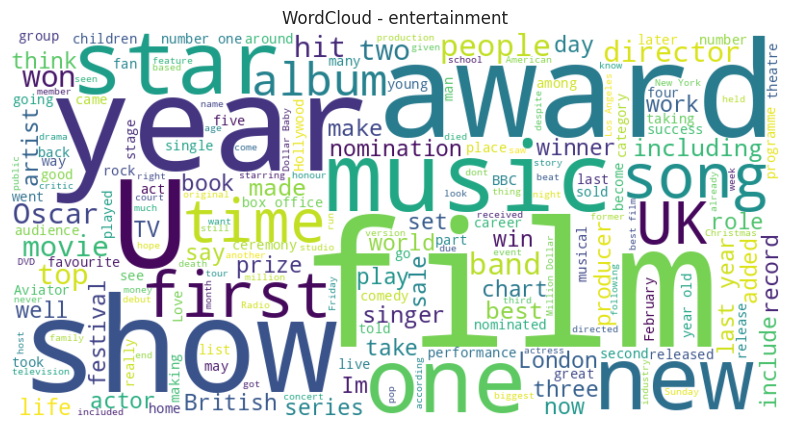

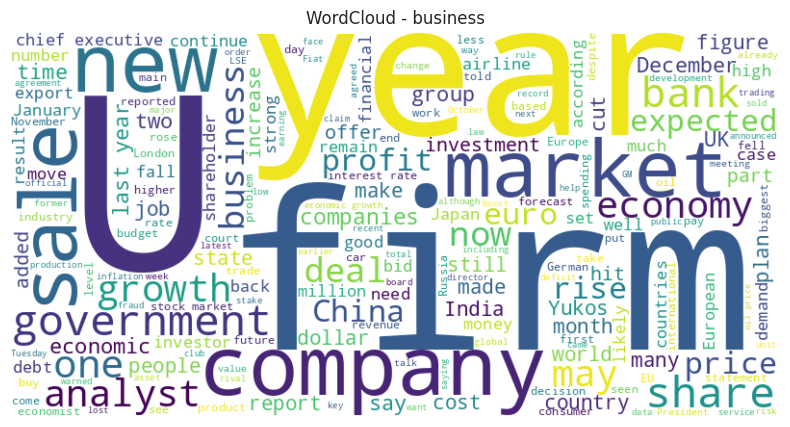

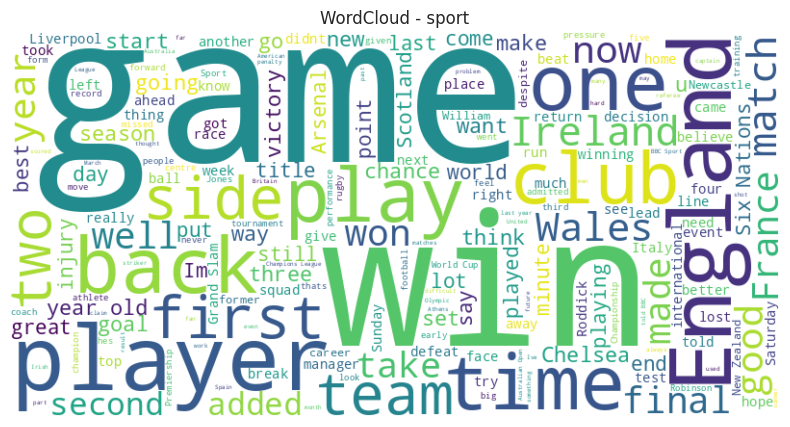

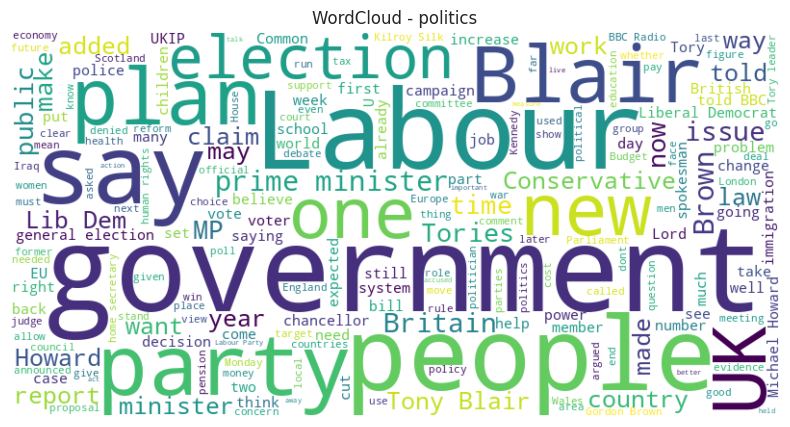

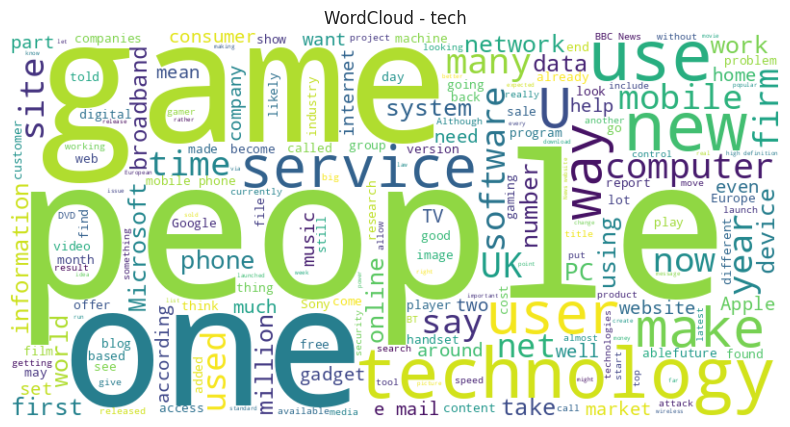

In [ ]:
for label in df['label'].unique():
    text = ' '.join(df[df['label'] == label]['description'])
    wc = WordCloud(width=800, height=400, background_color='white',stopwords=stop_words).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud - {label}')
    plt.axis('off')
    plt.show()

## Data split (Train Test Split)

In [ ]:
X= df['description']
y= df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)
data_train = pd.concat([X_train, y_train], axis = 1)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 40)
data_val, data_test = pd.concat([X_val, y_val], axis = 1), pd.concat([X_test, y_test], axis = 1)

In [ ]:
data_train.count()

,0
description,1780
label,1780


In [ ]:
data_val.count()

,0
description,222
label,222


In [ ]:
data_split_ratio=np.array([len(data_train),len(data_val),len(data_test)]) / 100

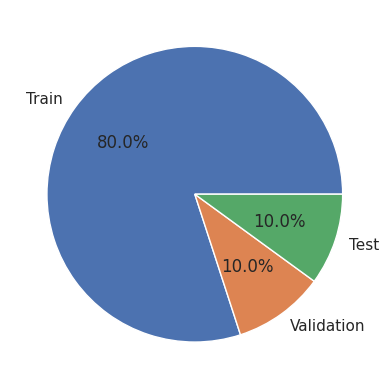

In [ ]:
plt.pie(data_split_ratio, labels = ['Train', 'Validation', 'Test'], autopct='%1.1f%%')
plt.show()

# Text Normalization

In [ ]:
regexp = RegexpTokenizer("[\w']+")

#### Converting to Lowercase

In bert-cased we wont be using convert_to_lowercase()

In [ ]:
def convert_to_lowercase(text):
  return text.lower()

text = "TeST FUncTion For ConvertIng"
print("Input: {}".format(text))
print("Output: {}".format(convert_to_lowercase(text)))

Input: TeST FUncTion For ConvertIng
Output: test function for converting


In [ ]:
def remove_whitespace(text):
    return text.strip()

text = " \t This is a string \t "
print("Input: {}".format(text))
print("Output: {}".format(remove_whitespace(text)))

Input:  	 This is a string 	 
Output: This is a string


In [ ]:
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

text = '<a href = "https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification"> Ecommerce Text Classification </a>'
print("Input: {}".format(text))
print("Output: {}".format(remove_html(text)))

Input: <a href = "https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification"> Ecommerce Text Classification </a>
Output:  Ecommerce Text Classification 


In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    return emoji_pattern.sub(r'', text)

text = "This innovative hd printing technique results in durable and spectacular looking prints 😊"
print("Input: {}".format(text))
print("Output: {}".format(remove_emoji(text)))

Input: This innovative hd printing technique results in durable and spectacular looking prints 😊
Output: This innovative hd printing technique results in durable and spectacular looking prints 


In [ ]:
def remove_http(text):
    http = "https?://\S+|www\.\S+"
    pattern = r"({})".format(http)
    return re.sub(pattern, "", text)

text = "It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols"
print("Input: {}".format(text))
print("Output: {}".format(remove_http(text)))

Input: It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols
Output: It's a function that removes links starting with http: or https such as 


Normalization pipeline without converting to lowercase.

In [ ]:
df['has_mention'] = df['description'].str.contains(r'@\w+')
df['has_hashtag'] = df['description'].str.contains(r'#\w+')
df['has_url'] = df['description'].str.contains(r'http\S+')
df['has_and'] = df['description'].str.contains(r'&\w+')


print(df.groupby('label')['has_mention'].mean())
print(df.groupby('label')['has_url'].mean())
print(df.groupby('label')['has_and'].mean())
print(df.groupby('label')['has_hashtag'].mean())

label
business         0.000000
entertainment    0.000000
politics         0.000000
sport            0.000000
tech             0.002494
Name: has_mention, dtype: float64
label
business         0.0
entertainment    0.0
politics         0.0
sport            0.0
tech             0.0
Name: has_url, dtype: float64
label
business         0.029412
entertainment    0.046632
politics         0.009592
sport            0.001957
tech             0.000000
Name: has_and, dtype: float64
label
business         0.001961
entertainment    0.005181
politics         0.011990
sport            0.009785
tech             0.022444
Name: has_hashtag, dtype: float64


In [ ]:
def normalization_bert_cased(text):
  text = remove_whitespace(text)
  text = re.sub('\n' , '', text)
  text = re.sub('\[.*?\]', '', text)
  text = re.sub(r'@', '', text)
  text = text.replace('&', 'and')
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'#', '', text)
  text = remove_http(text)
  text = remove_html(text)
  text = remove_emoji(text)
  text = re.sub(r'\s+', ' ', text).strip()
  return text

In [ ]:
text = "We'll combine all functions into 1 SINGLE FUNCTION 🙂 & apply on @product #descriptions https://en.wikipedia.org/wiki/Text_normalization"
print("Input: {}".format(text))
print("Output: {}".format(normalization_bert_cased(text)))

Input: We'll combine all functions into 1 SINGLE FUNCTION 🙂 & apply on @product #descriptions https://en.wikipedia.org/wiki/Text_normalization
Output: We'll combine all functions into 1 SINGLE FUNCTION and apply on product descriptions


In [ ]:
data_train_norm, data_val_norm, data_test_norm = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()


In [ ]:
data_train_norm['normalized_description']=data_train['description'].apply(normalization_bert_cased)
data_val_norm['normalized_description']=data_val['description'].apply(normalization_bert_cased)
data_test_norm['normalized_description']=data_test['description'].apply(normalization_bert_cased)

In [ ]:
data_train_norm['label'] = data_train['label']
data_val_norm['label'] = data_val['label']
data_test_norm['label'] = data_test['label']

In [ ]:
data_train_norm['label'] = data_train_norm['label'].map(label_dict)
data_val_norm['label'] = data_val_norm['label'].map(label_dict)
data_test_norm['label'] = data_test_norm['label'].map(label_dict)

In [ ]:
data_train_norm

,normalized_description,label
1918,Microsoft debuts security tools Microsoft is r...,3
628,Venezuela and China sign oil deal Venezuelan p...,1
2063,Gadget market to grow in 2005 The explosion in...,3
644,Pension hitch for long-living men Male life ex...,1
481,Worldcom ex-boss launches defence Lawyers defe...,1
...,...,...
626,BA to suspend two Saudi services British Airwa...,1
1863,Google launches TV search service The net sear...,3
1330,Fear will help France - Laporte France coach B...,0
2213,The Force is strong in Battlefront The warm re...,3


# Parameter Efficient Fine Tuning

In the context of fine-tuning large language models (LLMs), PEFT (Parameter-Efficient Fine-Tuning) techniques are designed to adapt huge pre-trained models to specific tasks efficiently by updating only a small subset of parameters rather than the entire model. This approach drastically reduces the computational cost and memory requirements, making fine-tuning accessible even with limited resources.

LoRA (Low-Rank Adaptation) is a popular PEFT method that injects trainable low-rank matrices into the existing weights of a pre-trained model. Instead of updating the full weight matrices, LoRA learns small low-rank updates which, when combined with the frozen original weights during inference, effectively adapt the model to new tasks. This method preserves the pre-trained knowledge while enabling efficient specialization.

By applying LoRA, it becomes possible to fine-tune very large models on downstream tasks like text classification, question answering, or summarization with significantly less data and faster training times. The low-rank updates capture task-specific information and improve model performance, while maintaining the original model’s capabilities through parameter sharing.

## LoRA Fine tuning `bert-base-cased`

We are starting with initializing the configuration parameters for lora and model. After that we are using PyTorch dataset and dataloader to feed the data into the model. When we finetuning the model, we will use Adam as our optimizer and crossentropy loss as our loss function, and we will train the model with 3 epochs.

In [ ]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [ ]:
model_id = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(model_id)

base_model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=len(set(y_train))
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
lora_config=LoraConfig(
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

In [ ]:
model= get_peft_model(base_model,lora_config)
model.print_trainable_parameters()
model.to(device)

trainable params: 298,757 || all params: 108,612,874 || trainable%: 0.2751


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(28996, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default

#### Creating TextDataset class with Torch Dataset.

__len__ returning the length of the text.

__getitem__ returning the text data with index. data[index]



In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }


#### Defining X and y variables for bert model.

We will be training the model with:
`X_train_bert and
y_train_bert`

In [ ]:
X_train_bert = data_train_norm['normalized_description'].tolist()
y_train_bert = data_train_norm['label'].tolist()

X_val_bert = data_val_norm['normalized_description'].tolist()
y_val_bert = data_val_norm['label'].tolist()


X_test_bert = data_test_norm['normalized_description'].tolist()
y_test_bert = data_test_norm['label'].tolist()

In [ ]:
train_dataset_bert = TextDataset(X_train_bert, y_train_bert, tokenizer)
val_dataset_bert   = TextDataset(X_val_bert, y_val_bert, tokenizer)

train_loader_bert = DataLoader(train_dataset_bert, batch_size=16, shuffle=True)
val_loader_bert   = DataLoader(val_dataset_bert, batch_size=16)


In [ ]:
print(train_dataset_bert[0])

{'input_ids': tensor([  101,  6998,  1963,  1116,  2699,  5537,  6998,  1110,  8210,  5537,
         1115,  4044,  1146,  7054,  1116, 11614,  1158, 20942,  1105, 10669,
         7109,   119,  1109,  7942,   118,  2935,  1788,  1209,  1129,  8054,
         7868,  1105,  1110,   170, 15985,  1106,  6998,  8210,  3256,  2848,
          118,  7942,  3594,   119,  2907,  1217,  1308,  1110,   170,  3594,
        10345,  1115,  1209,  1494,  4713,  1525,  1105,  5782,  1251, 10669,
         7109,  1113,  1147,  1313,  2775,   119,  1966,  2786,  1714,  1122,
         1110,  1354,  1115,  1770,  6998,  1209,  1129, 13758,  4713,  1111,
         1103,  2848,   118, 10669,  7109,  6806,   119,  1109,  2848,   118,
        10669,  7109,  6806,  1110,  1907,  1208,  1105,  1103,  2848,   118,
         7942, 10345,  1110,  2637,  1106,  1129,  1907,  1224,  1142,  2370,
          119,  6998,  1116,  5647,  3389,  1449,  1144,  1263,  1151,   170,
         9122,  1104,  1234,  1150,  3593,  2775, 

#### Defining the optimizer and loss parameters

In [ ]:
optimizer=AdamW(model.parameters(),lr=0.00002)
criterion=nn.CrossEntropyLoss()

epochs=8

In [ ]:
for epoch in range(epochs):
    model.train()
    loop = tqdm(train_loader_bert, desc=f"Epoch {epoch+1}")
    total_loss = 0

    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)


        labels = labels.long()
        labels = labels.squeeze()

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} loss: {total_loss / len(train_loader_bert):.3f}")


Epoch 1: 100%|██████████| 112/112 [00:20<00:00,  5.40it/s, loss=1.37]


Epoch 1 loss: 1.602


Epoch 2: 100%|██████████| 112/112 [00:20<00:00,  5.41it/s, loss=1.64]


Epoch 2 loss: 1.570


Epoch 3: 100%|██████████| 112/112 [00:20<00:00,  5.45it/s, loss=1.48]


Epoch 3 loss: 1.489


Epoch 4: 100%|██████████| 112/112 [00:20<00:00,  5.43it/s, loss=1.14]


Epoch 4 loss: 1.239


Epoch 5: 100%|██████████| 112/112 [00:20<00:00,  5.41it/s, loss=0.923]


Epoch 5 loss: 1.021


Epoch 6: 100%|██████████| 112/112 [00:20<00:00,  5.40it/s, loss=0.803]


Epoch 6 loss: 0.863


Epoch 7: 100%|██████████| 112/112 [00:20<00:00,  5.41it/s, loss=0.743]


Epoch 7 loss: 0.723


Epoch 8: 100%|██████████| 112/112 [00:20<00:00,  5.42it/s, loss=0.444]

Epoch 8 loss: 0.617


In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader_bert:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

val_acc_3 = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {val_acc_3:.3f}")


Validation Accuracy: 0.878


In [ ]:
print(outputs)

SequenceClassifierOutput(loss=None, logits=tensor([[ 3.6336, -2.2139, -2.4010, -0.3893,  1.1044],
        [-2.2665,  1.4672,  0.6742,  2.5306,  0.2531],
        [-1.1690, -0.1362, -0.5057,  2.3856,  1.9601],
        [-1.6274,  0.4297, -0.2164,  2.7576,  1.4289],
        [-0.2724, -0.9716, -0.9943,  1.7363,  2.3025],
        [-1.9080,  0.8867,  0.0950,  2.7139,  0.9154],
        [-3.5132,  2.6420,  2.5418,  0.5196, -1.4665],
        [ 0.8867, -1.5298, -1.4897,  1.0739,  2.6367],
        [ 3.6308, -2.1493, -2.2813, -0.3757,  1.0680],
        [-0.3511, -0.9510, -0.9312,  1.8371,  2.2517],
        [-3.6004,  2.6214,  2.6882,  0.3153, -1.5777],
        [-3.6360,  2.6522,  2.7026,  0.3277, -1.6086],
        [ 3.4152, -2.1797, -2.4085, -0.2861,  1.2253],
        [-1.5054,  0.4536, -0.1824,  2.5548,  1.2758]], device='cuda:0'), hidden_states=None, attentions=None)


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98        51
           1       0.85      0.77      0.81        52
           2       0.79      0.87      0.82        38
           3       0.85      0.91      0.88        44
           4       0.91      0.86      0.89        37

    accuracy                           0.88       222
   macro avg       0.88      0.88      0.88       222
weighted avg       0.88      0.88      0.88       222



In [ ]:
pd.Series(all_labels).value_counts()

,count
1,52
0,51
3,44
2,38
4,37


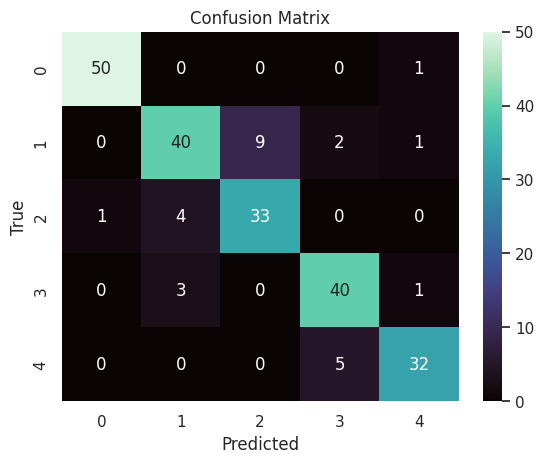

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='mako')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

save_dir = '/content/drive/MyDrive/colab files/bert-base-cased'

# Eğer klasör yoksa oluştur
os.makedirs(save_dir, exist_ok=True)

In [ ]:
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)


('/content/drive/MyDrive/colab files/bert-base-cased/tokenizer_config.json',
 '/content/drive/MyDrive/colab files/bert-base-cased/special_tokens_map.json',
 '/content/drive/MyDrive/colab files/bert-base-cased/vocab.txt',
 '/content/drive/MyDrive/colab files/bert-base-cased/added_tokens.json')

## LoRA Fine tuning `bert-base-uncased`

We are starting with initializing the configuration parameters for lora and model. After that we are using PyTorch dataset and dataloader to feed the data into the model. When we finetuning the model, we will use Adam as our optimizer and crossentropy loss as our loss function, and we will train the model with 3 epochs.

In this step, we will be converting text lowercase and will use bert-base-uncased model

In [ ]:
def normalization_bert_uncased(text):
  text = convert_to_lowercase(text)
  text = remove_whitespace(text)
  text = re.sub('\n' , '', text)
  text = re.sub('\[.*?\]', '', text)
  text = re.sub(r'@', '', text)
  text = text.replace('&', 'and')
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'#', '', text)
  text = remove_http(text)
  text = remove_html(text)
  text = remove_emoji(text)
  text = re.sub(r'\s+', ' ', text).strip()
  return text

In [ ]:
text = "We'll combine all functions into 1 SINGLE FUNCTION 🙂 & apply on @product #descriptions https://en.wikipedia.org/wiki/Text_normalization"
print("Input: {}".format(text))
print("Output: {}".format(normalization_bert_uncased(text)))

Input: We'll combine all functions into 1 SINGLE FUNCTION 🙂 & apply on @product #descriptions https://en.wikipedia.org/wiki/Text_normalization
Output: we'll combine all functions into 1 single function and apply on product descriptions


#### Normalizing the data for bert-base-uncased

In [ ]:
data_train_norm_uncased,data_test_norm_uncased,data_val_norm_uncased = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

In [ ]:
data_train_norm_uncased['normalized_description'] = data_train['description'].apply(normalization_bert_uncased)
data_test_norm_uncased['normalized_description'] = data_test['description'].apply(normalization_bert_uncased)
data_val_norm_uncased['normalized_description'] = data_val['description'].apply(normalization_bert_uncased)

In [ ]:
data_train_norm_uncased['label'] = data_train['label']
data_val_norm_uncased['label'] = data_val['label']
data_test_norm_uncased['label'] = data_test['label']

data_train_norm_uncased['label'] = data_train_norm_uncased['label'].map(label_dict)
data_val_norm_uncased['label'] = data_val_norm_uncased['label'].map(label_dict)
data_test_norm_uncased['label'] = data_test_norm_uncased['label'].map(label_dict)

In [ ]:
model_id = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(model_id)

model_2 = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=len(set(y_train))
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Creating Dataset and DataLoader for training
We will be using the same lora configurations.

In [ ]:
#model_2.unload()

In [ ]:
model_2=get_peft_model(model_2,lora_config)
model_2.print_trainable_parameters()
model_2.to(device)

In [ ]:
X_train_bert_uncased = data_train_norm_uncased['normalized_description'].tolist()
y_train_bert_uncased = data_train_norm_uncased['label'].tolist()

X_val_bert_uncased = data_val_norm_uncased['normalized_description'].tolist()
y_val_bert_uncased = data_val_norm_uncased['label'].tolist()


X_test_bert_uncased = data_test_norm_uncased['normalized_description'].tolist()
y_test_bert_uncased = data_test_norm_uncased['label'].tolist()

In [ ]:
train_dataset_bert_uncased = TextDataset(X_train_bert_uncased, y_train_bert_uncased, tokenizer)
val_dataset_bert_uncased   = TextDataset(X_val_bert_uncased,y_val_bert_uncased,tokenizer)

train_loader_bert_uncased = DataLoader(train_dataset_bert_uncased, batch_size=16, shuffle=True)
val_loader_bert_uncased   = DataLoader(val_dataset_bert_uncased, batch_size=16)



In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

epochs=3


In [ ]:
for epoch in range(epochs):
    model_2.train()
    loop = tqdm(train_loader_bert_uncased, desc=f"Epoch {epoch+1}")
    total_loss = 0

    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)


        labels = labels.long()
        labels = labels.squeeze()

        optimizer.zero_grad()
        outputs = model_2(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} loss: {total_loss / len(train_loader_bert_uncased):.3f}")


Epoch 1: 100%|██████████| 112/112 [00:23<00:00,  4.86it/s, loss=1.61]


Epoch 1 loss: 1.613


Epoch 2: 100%|██████████| 112/112 [00:22<00:00,  4.90it/s, loss=1.6]


Epoch 2 loss: 1.577


Epoch 3: 100%|██████████| 112/112 [00:22<00:00,  4.93it/s, loss=1.27]

Epoch 3 loss: 1.516


In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
  model.eval()
  for batch in val_loader_bert_uncased:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["label"].to(device)

    outputs = model_2(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

val_acc_3 = accuracy_score(all_labels, all_preds)

print(val_acc_3)



0.509009009009009
